In [527]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg
import time
import matplotlib.pyplot as plt

Problem 1

In [528]:
def coveriance_matrix(m):
    mean_vector = np.mean(m, axis=0)
    centered_data = m - mean_vector
    covariance_matrix = np.dot(centered_data.T, centered_data) / (m.shape[0] - 1)
    return covariance_matrix

In [529]:
def exponentially_weighted_covariance(m, lamb):
    col, row = m.shape
    weights = np.zeros((col, row))
    weights[0, :] = 1
    for i in range(1, col):
        weights[i, :] = weights[i-1, :] * lamb
    weighted_m = m * weights
    cov_matrix = coveriance_matrix(weighted_m)
    return cov_matrix

In [530]:
def calculate_cumulative_variance_explained(m, lamb):
    cov_matrix = exponentially_weighted_covariance(m, lamb)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues = np.real(eigenvalues)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    cumulative_variance_explained = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    return cumulative_variance_explained

In [531]:
def plot_cumulative_variance(m, lambs):
    fig, ax = plt.subplots(figsize=(8, 6))
    for lamb in lambs:
        cumulative_variance_explained = calculate_cumulative_variance_explained(m, lamb)
        ax.plot(cumulative_variance_explained, label=f"lambda={lamb}")
    ax.legend()
    ax.set_xlabel("# of Principal Components")
    ax.set_ylabel("Cumulative Variance Explained")
    plt.show()

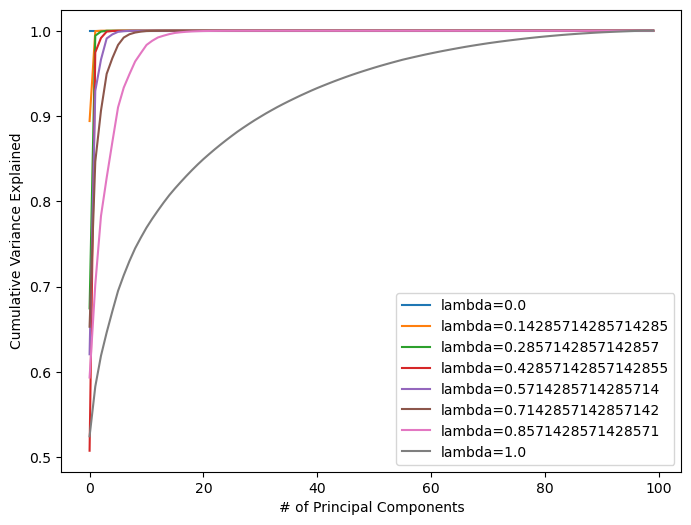

In [532]:
data = pd.read_csv("DailyReturn.csv").iloc[:, 1:].values
lambs = np.linspace(0, 1, 8)
plot_cumulative_variance(data, lambs)

Problem 2

function chol_psd!(root,a)
    n = size(a,1)
    #Initialize the root matrix with 0 values
    root .= 0.0

    #loop over columns
    for j in 1:n
        s = 0.0
        #if we are not on the first column, calculate the dot product of the preceeding row values.
        if j>1
            s =  root[j,1:(j-1)]'* root[j,1:(j-1)]
        end
  
        #Diagonal Element
        temp = a[j,j] .- s
        if 0 >= temp >= -1e-8
            temp = 0.0
        end
        root[j,j] =  sqrt(temp);

        #Check for the 0 eigan value.  Just set the column to 0 if we have one
        if 0.0 == root[j,j]
            root[j,(j+1):n] .= 0.0
        else
            #update off diagonal rows of the column
            ir = 1.0/root[j,j]
            for i in (j+1):n
                s = root[i,1:(j-1)]' * root[j,1:(j-1)]
                root[i,j] = (a[i,j] - s) * ir 
            end
        end
    end
end

In [533]:
# Rewrite chol_psd() in python

def chol_psd(a):
    n = a.shape[0]
    root = np.zeros((n,n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        temp = a[j,j] - s
        if temp <= 0 and abs(temp) < 1e-8:
            temp = 0.0
        root[j,j] = np.sqrt(temp)
        if root[j,j] == 0.0:
            root[j,(j+1):n] = 0.0
        else:
            ir = 1.0 / root[j,j]
            for i in range(j+1,n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i,j] = (a[i,j] - s) * ir

    return root

function near_psd(a; epsilon=0.0)
    n = size(a,1)

    invSD = nothing
    out = copy(a)

    #calculate the correlation matrix if we got a covariance
    if count(x->x ≈ 1.0,diag(out)) != n
        invSD = diagm(1 ./ sqrt.(diag(out)))
        out = invSD * out * invSD
    end

    #SVD, update the eigen value and scale
    vals, vecs = eigen(out)
    vals = max.(vals,epsilon)
    T = 1 ./ (vecs .* vecs * vals)
    T = diagm(sqrt.(T))
    l = diagm(sqrt.(vals))
    B = T*vecs*l
    out = B*B'

    #Add back the variance
    if invSD !== nothing 
        invSD = diagm(1 ./ diag(invSD))
        out = invSD * out * invSD
    end
    return out
end


In [534]:
def near_psd(a, epsilon=0):
    invSD = None
    out = a.copy()

    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = 1.0 / np.dot((vecs * vecs), vals)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = np.dot(np.dot(T, vecs), l)
    out = np.dot(B, B.T)

    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = np.dot(np.dot(invSD, out), invSD)
    return out

Higham's 2002

In [535]:
def Pu(matrix):
    result = matrix.copy()
    np.fill_diagonal(result, 1)
    return result

In [536]:
def Ps(matrix, weight):
    ps = np.sqrt(weight)@ matrix @np.sqrt(weight)
    vals, vecs = np.linalg.eigh(ps)
    vals = np.array([max(i,0) for i in vals])
    result = np.sqrt(weight) @ vecs @ np.diagflat(vals) @ vecs.T @ np.sqrt(weight)
    return result

In [537]:
def frobenius_norm(matrix_1, matrix_2):
    gamma = matrix_1 - matrix_2
    result = 0
    for i in range(len(gamma)):
        for j in range(len(gamma)):
            result += gamma[i][j]**2
    return result

In [538]:
def higham_2002(matrix, weight = None, epsilon = 1e-9, max_iter = 1000, tolerance = 1e-8):

    if weight is None:
        weight = np.identity(len(matrix))
        
    norml = np.inf
    Yk = matrix.copy()
    Delta_S = np.zeros_like(Yk)
    
    invSD = None
    if np.count_nonzero(np.diag(Yk) == 1.0) != matrix.shape[0]:
        invSD = np.diag(1 / np.sqrt(np.diag(Yk)))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    
    Y0 = Yk.copy()

    for i in range(max_iter):
        Rk = Yk - Delta_S
        Xk = Ps(Rk, weight)
        Delta_S = Xk - Rk
        Yk = Pu(Xk)
        norm = frobenius_norm(Yk, Y0)
        minEigVal = np.real(np.linalg.eigvals(Yk)).min()
        if abs(norm - norml) < tolerance and minEigVal > -epsilon:
            break
        else:
            norml = norm
    
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        Yk = np.matmul(np.matmul(invSD, Yk), invSD)
    return Yk

In [539]:
def is_psd(matrix):
    eigenvalues = np.linalg.eigh(matrix)[0]
    return np.all(eigenvalues >= -1e-8)

In [540]:
print("Original matrix: ", is_psd(sigma))
print("Matrix fixed with near_psd(): ", is_psd(near_psd(sigma)))
print("Matrix fixed with Higham_psd(): ", is_psd(higham_2002(sigma)))

Original matrix:  False
Matrix fixed with near_psd():  True
Matrix fixed with Higham_psd():  True


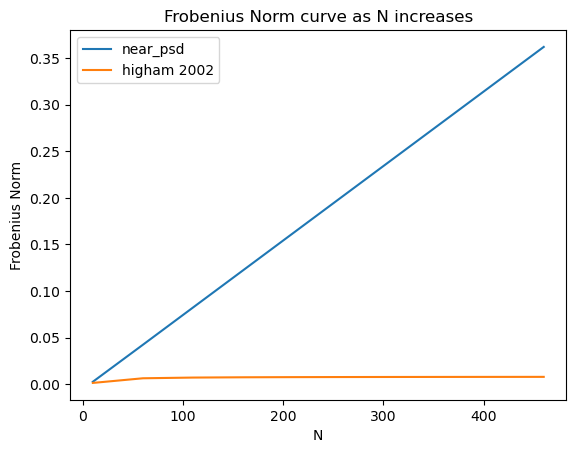

In [541]:
n_range = np.arange(10, 500, 50)
frobenius_norms_near = []
frobenius_norms_higham = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    sigma_fixed_near = near_psd(sigma_current)
    frobenius_norm_near = frobenius_norm(sigma_current, sigma_fixed_near)
    frobenius_norms_near.append(frobenius_norm_near)
    
    sigma_fixed_higham = higham_2002(sigma_current)
    frobenius_norm_higham = frobenius_norm(sigma_current, sigma_fixed_higham)
    frobenius_norms_higham.append(frobenius_norm_higham)


plt.plot(n_range, frobenius_norms_near, label='near_psd')
plt.plot(n_range, frobenius_norms_higham, label='higham 2002')
plt.xlabel('N')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm curve as N increases')
plt.legend()
plt.show()

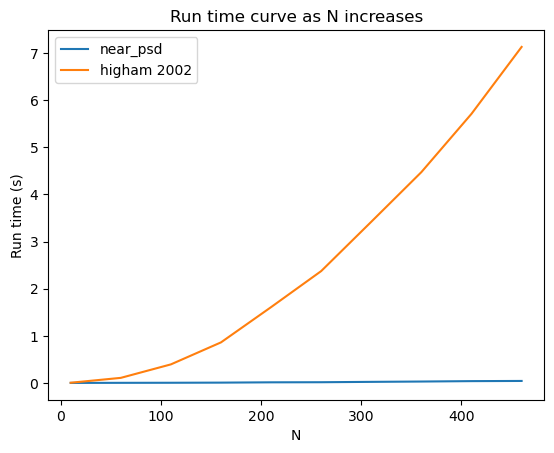

In [542]:
n_range = np.arange(10, 500, 50)
time_near_psd = []
time_higham_psd = []
for n_current in n_range:
    sigma_current = sigma[:n_current, :n_current]
    
    start_time = time.time()
    sigma_fixed_near = near_psd(sigma_current)
    time_near = time.time() - start_time
    time_near_psd.append(time_near)
    
    start_time = time.time()
    sigma_fixed_higham = higham_2002(sigma_current)
    time_higham = time.time() - start_time
    time_higham_psd.append(time_higham)

plt.plot(n_range, time_near_psd, label='near_psd')
plt.plot(n_range, time_higham_psd, label='higham 2002')
plt.xlabel('N')
plt.ylabel('Run time (s)')
plt.title('Run time curve as N increases')
plt.legend()
plt.show()

Problem 3

In [543]:
data = pd.read_csv("DailyReturn.csv").iloc[:, 1:].values

In [544]:
# Standard Pearson correlation/variance
def pearson_correlation(df):
    cov_matrix = np.cov(df.T)
    cor_matrix = np.corrcoef(df.T)
    return cor_matrix

def variance(df):
    var_vector = np.var(df, axis=0)
    return var_vector

In [545]:
# Exponentially weighted variance with lambda = 0.97
def exponential_weighted_variance(df, lamb=0.97):
    col = df.shape[0]
    weights = np.exp(np.linspace(0, -(col-1), col)*np.log(lamb))
    weighted_var = np.average(df**2, axis=0, weights=weights)
    return weighted_var

In [546]:
# Define a function for PCA simulation
def pca_simulation(cov_matrix, explained_variance=1.0, num_draws=25000):
    num_stocks = cov_matrix.shape[0]
    mean = np.zeros(num_stocks)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]
    eigenvalues = eigenvalues[:int(explained_variance*num_stocks)]
    eigenvectors = eigenvectors[:, :int(explained_variance*num_stocks)]
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    draws = np.dot(np.random.randn(num_draws, int(explained_variance*num_stocks)), np.diag(sqrt_eigenvalues))
    draws = np.dot(draws, eigenvectors.T) + mean
    return draws

In [547]:
# Generate the four matrices
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
standardized_data = (data - mean) / std
cov_matrix_pearson = np.cov(standardized_data.T)
lambda_ = 0.97
cov_matrix_ew = np.zeros(cov_matrix_pearson.shape)
for i in range(cov_matrix_pearson.shape[0]):
    for j in range(cov_matrix_pearson.shape[1]):
        cov_matrix_ew[i, j] = lambda_ * cov_matrix_ew[i, j] + (1 - lambda_) * returns[:, i].T @ returns[:, j] / returns.shape[0]
cov_matrix_pearson_var = np.diag(np.var(returns, axis=0))
cov_matrix_ew_var = np.diag(np.var(returns, axis=0))
cov_matrices = [cov_matrix_pearson, cov_matrix_ew, cov_matrix_pearson_var, cov_matrix_ew_var]

In [549]:
explained = [1, 0.75, 0.5]
for i, cov_matrix in enumerate(cov_matrices):
    print(i+1)
    start_time = time.time()
    draws = np.random.multivariate_normal(mean, cov_matrix, 25000)
    direct_sim_time = time.time() - start_time
    cov_sim = np.cov(draws, rowvar=False)
    norm = np.linalg.norm(cov_sim - cov_matrix, ord='fro')
    print("Direct simulation time is ", direct_sim_time)
    for j, explained_variance in enumerate(explained):
        start_time = time.time()
        draws = pca_simulation(cov_matrix, explained_variance, 25000)
        pca_sim_time = time.time() - start_time
        cov_sim = np.cov(draws, rowvar=False)
        norm = np.linalg.norm(cov_sim - cov_matrix, ord='fro')
        print("When explained variance = ", explained_variance, "simulation time is ", pca_sim_time)
    print("\n")

1
Direct simulation time is  0.15433216094970703
When explained variance =  1 simulation time is  0.1537330150604248
When explained variance =  0.75 simulation time is  0.10342788696289062
When explained variance =  0.5 simulation time is  0.08644628524780273


2
Direct simulation time is  0.10660195350646973
When explained variance =  1 simulation time is  0.11661100387573242
When explained variance =  0.75 simulation time is  0.08849215507507324
When explained variance =  0.5 simulation time is  0.06874370574951172


3
Direct simulation time is  0.09734606742858887
When explained variance =  1 simulation time is  0.10938882827758789
When explained variance =  0.75 simulation time is  0.08109402656555176
When explained variance =  0.5 simulation time is  0.05746912956237793


4
Direct simulation time is  0.11453008651733398
When explained variance =  1 simulation time is  0.10532307624816895
When explained variance =  0.75 simulation time is  0.08717703819274902
When explained varianc